# ASE Scripts for Jupyter-notebook
- Ara Cho, Jan. 2023 @POSTECH

# 1. Viewer

## 1.1. ase-notebook

https://ase-notebook.readthedocs.io/en/latest/index.html

conda install -c conda-forge ase-notebook

### 1.1.1. Configuration
- **ViewConfig**, which validates and stores the initialisation configuration.
- **AseView**, which uses a ViewConfig to create a visualisation, via one of the backends.

In [1]:
%matplotlib inline
from ase_notebook import AseView, ViewConfig, get_example_atoms

config = ViewConfig()
ase_view = AseView(config)
ase_view = AseView(
    rotations="45x,45y,45z",
    atom_font_size=15,
    axes_length=30,
    canvas_size=(400, 400),
    zoom=1.2, #"3D camera zoom."
    show_bonds=True, # "Show atomic bonds."
    atom_show_label=True,
    atom_label_by="index", # "element", "index", "tag", "magmom", "charge", "array"
    atom_lighten_by_depth = 0.0,
    radii_scale=1.2,
    bond_opacity=1.0,
    bond_pairs_filter=[('Li', 'S'), ('S', 'S')], # show Li-S, S-S bond only
)
ase_view.config.uc_dash_pattern=(.6,.4) # "help": "A (length, gap) dash pattern for unit cell lines."
ase_view.config.canvas_color_background = "white"
ase_view.config.canvas_background_opacity = 0.2

### 1.1.2 get example atoms object

In [2]:
atoms = get_example_atoms()

### 1.1.3. 3D

In [3]:
gui = ase_view.make_render(
    atoms, center_in_uc=True)
gui

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 75.7451577710053), pr…

### 1.1.4. 2D

To use `concatenate_svgs`, the package must have been installed via Conda or with the `svgconcat` extra: `pip install ase-notebook[svgconcat]`.

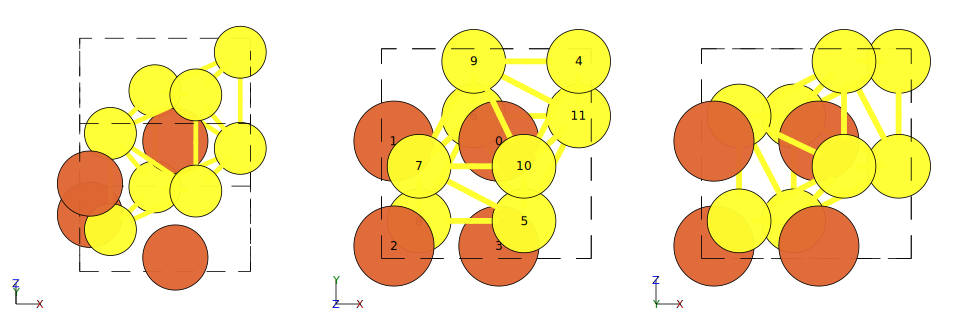

In [4]:
def atoms_view(atoms):
    from ase_notebook import concatenate_svgs
    svgs = []
    for rot in ["-60x", "0x", "-90x"]: #["-45x,-45y,-45z", "0x", "-90x"]
        ase_view.config.rotations = rot
        if rot == "0x":
            ase_view.config.atom_show_label = True
        else:
            ase_view.config.atom_show_label = False
        svgs.append(
            ase_view.make_svg(atoms, center_in_uc=False)
        )
    return concatenate_svgs(
        svgs, max_columns=3, scale=0.8, label=False)

atoms_view(atoms)

## 1.2. ase.visualize.plot
https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html
- Plot using matplotlib

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

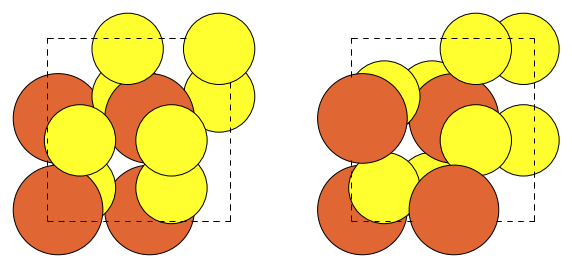

In [5]:
from matplotlib import pyplot as plt
from ase.visualize.plot import plot_atoms

def ase_matplot(atoms):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    plot_atoms(atoms, ax[0], rotation=('0x,0y,0z'))
    plot_atoms(atoms, ax[1], rotation=('-90x,0y,0z'))
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    return fig, ax

ase_matplot(atoms)

# 2. Generate input files for adsorption calculation

In [6]:
from ase import Atom, Atoms
from ase.io import read, write
from ase.build import add_adsorbate
import subprocess
import os

final_file='final_with_calculator.json' # or CONTCAR

research_folder='/Users/aracho/Dropbox/0_Research/0_My_Publications/dct/Research_Note/01_LiS'
gas_fol='/Users/aracho/Dropbox/0_Research/0_My_Publications/dct/Research_Note/00_gas/VASP5.3.5/PBE/DFT-D3'

numlist=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16',
        '18','19','20','21','22','23','24','25','26','27','28']

def get_ads_atoms(species):
    atoms=read(gas_fol+'/{}/{}'.format(species,final_file))
    return atoms

def make_ads_input(slab_atoms, adsorbate,sites_index,height=4.0,mol_index=0,rot=['z0'],i=0):
    
    """ indicate adsorbtion sites """
    if isinstance(sites_index, str):
        site_info = [atom for atom in slab_atoms if atom.z < 4 and atom.z >2]
    else:
        site_info = [atom for atom in slab_atoms if atom.index in sites_index]

    sites=[]
    for site in site_info:
        sites.append((site.x, site.y))

    adsorbate=get_ads_atoms(adsorbate)
    adsorbate=Atoms(adsorbate,pbc=slab_atoms.pbc,cell=slab_atoms.cell)
    adsorbate.center()

    if rot:
        for za in rot:
            if za[0].lower() in 'xyz':
                axis = za[0].lower()
                angle = za[1:]
            else:
                axis = 'z'
                angle = za

            try:
                angle = float(angle)
            except:
                print("Please enter valid rotation parameter, e.g. z90!")
                raise
            adsorbate.rotate(angle, axis)

    i=i     
    new_file='restart.json'
    for site in sites:
        if len(sites) == 1:
            ads_atoms=slab_atoms.copy()
            add_adsorbate(ads_atoms, adsorbate, height, position=site,mol_index=mol_index)
            write(new_file,ads_atoms.repeat((1,1,1)))
            print('generate :{}'.format(new_file))
            display(atoms_view(ads_atoms))
        else:
            ads_atoms=slab_atoms.copy()
            add_adsorbate(ads_atoms, adsorbate, height, position=site,mol_index=mol_index)
            subprocess.call('mkdir ./{}'.format(numlist[i]), shell=True)
            write('./{}/{}'.format(numlist[i],new_file),ads_atoms)
            print('generate {}:{}'.format(numlist[i],new_file))
            display(atoms_view(ads_atoms))
            i+=1  


## 2.1. Example: Li2S2 adsorption on Pt(111)
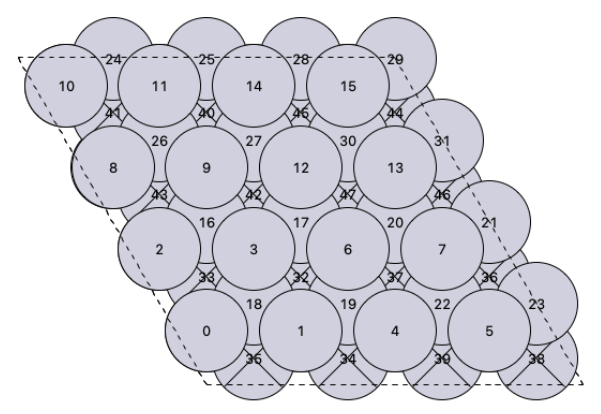

generate 01:restart.json


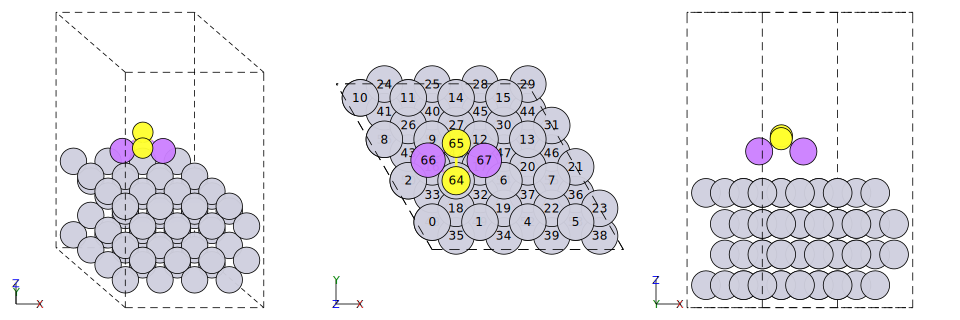

generate 02:restart.json


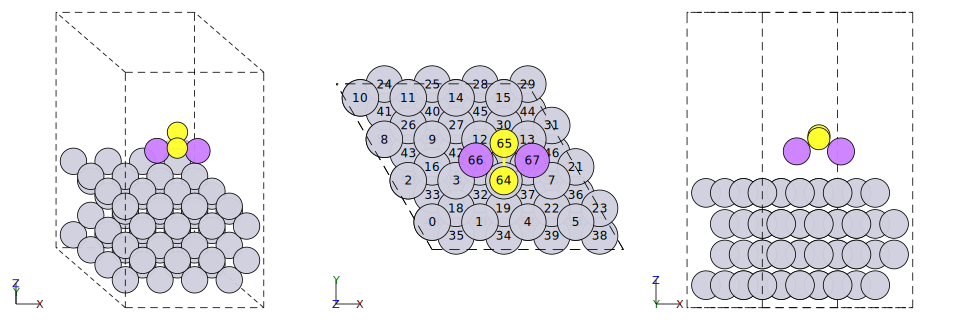

In [7]:
""" set calculation folder """
slab_fol=research_folder+'/01-Pt/05_clean'
ads_fol=slab_fol+'/Li2S2'

""" cd ads_fol """
os.chdir(ads_fol)

""" get atoms object for slab """
slab_atoms=read(slab_fol+'/'+final_file)


"""
slab_atoms: atoms object for slab
adsorbate: adsorbate name ; string
sites_index: index number of the place to be adsorbed ; list
             if len(list) > 1, folder will be generated. 
height: The distance between the adsorbate and the surface. The reference is mol_index.
mol_index: Index number of adsorbate to be the reference
rot: rotation ['z0'] or ['z0','x90']
i: The first number on which the folder is created. (i.g, when i=0, folders are created in the order of 01, 02..; 
                                                          when i=2 -> 03, 04..)
"""

make_ads_input(slab_atoms,adsorbate='Li2S2',sites_index=[3,6],height=4.0,mol_index=0,rot=['z0'],i=0)

In [8]:
ls

01/ 02/
